Nathan Deinlein <br>
Ryan Kinney <br>
Chris Roche <br>
Cameron Stewart <br>

# Machine Learning 1 - Lab 3 Clustering

## Section 1: Business Understanding 1

Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

...

## Section 2: Data Understanding 1

Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

...

### Sub-Section 1.1: Load in and Prepare Data

#### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.model_selection import cross_validate
from sklearn.cluster import SpectralClustering
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#### Read in data

In [2]:
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)
print('Data set shape:',runs_df.shape)
runs_df.head()

Data set shape: (79423, 29)


,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


#### Create Show Variable

In [3]:
runs_df['show'] = np.where(runs_df['result'] <= 3, 1, 0)
runs_df.head()

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id,show
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2,0
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57,0
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18,0
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59,0
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154,0


#### Remove variables that are not needed/useful for the analysis

In [4]:
runs_data = runs_df.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id','show'], axis=1)
runs_target = runs_df['won']
runs_target2 = runs_df['show']
print('Predictor data set shape after dropping non-important predictors \nand separating response variables into their own data sets: \n',runs_data.shape)
runs_data.head()

Predictor data set shape after dropping non-important predictors 
and separating response variables into their own data sets: 
 (79423, 10)


,horse_no,horse_age,horse_country,horse_type,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds
0,1,3,AUS,Gelding,60,1020.0,133,7,9.7,3.7
1,2,3,NZ,Gelding,60,980.0,133,12,16.0,4.9
2,3,3,NZ,Gelding,60,1082.0,132,8,3.5,1.5
3,4,3,SAF,Gelding,60,1118.0,127,13,39.0,11.0
4,5,3,GB,Gelding,60,972.0,131,14,50.0,14.0


#### One-Hot Encode Categorical Variables

In [5]:
tmp_df = pd.get_dummies(runs_data.horse_country,prefix='horse_country')
runs_df_onehot = pd.concat((runs_data,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(runs_data.horse_type,prefix='horse_type')
runs_df_onehot = pd.concat((runs_df_onehot,tmp_df),axis=1) # add back into the dataframe

runs_data = runs_df_onehot.reset_index(drop=True)
runs_data = runs_data.drop(['horse_country','horse_type'], axis=1)

print('Shape after One-Hot Encoding Categorical Predictors:',runs_data.shape)
runs_data.head()

Shape after One-Hot Encoding Categorical Predictors: (79423, 33)


,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
0,1,3,60,1020.0,133,7,9.7,3.7,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2,3,60,980.0,133,12,16.0,4.9,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,3,60,1082.0,132,8,3.5,1.5,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,3,60,1118.0,127,13,39.0,11.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,3,60,972.0,131,14,50.0,14.0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [6]:
cv = StratifiedKFold(n_splits = 10, shuffle = True ,random_state = 0)

In [7]:
# training test split for showing confusion matrix
# Note all evaluation will actually use kFold CrossValidation

#train test split won
X_train,X_test,Y_train,Y_test = train_test_split(runs_data,runs_target,test_size=0.20,random_state=0)
scaler = StandardScaler()
X_train =scaler.fit_transform(X_train,y = None)
X_test = scaler.transform(X_test)

#train test split place
X_train_place,X_test_place,Y_train_place,Y_test_place = train_test_split(runs_data,runs_target2,test_size=0.20,random_state=0)
X_train_place = scaler.fit_transform(X_train_place,y = None)
X_test_place = scaler.transform(X_test_place)

## Section 3: Data Understanding 2

Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

...

## Section 4: Modeling and Evaluation 1

## Kmeans

In [8]:
init = [1,2,5,7,9,10,20,30]
for x in init:
    kmeans = KMeans(init='k-means++', n_clusters=2,max_iter=50, n_init=x, random_state=0)
    kmeans.fit(X_train,Y_train)
    y_hat = kmeans.predict(X_test)
    acc = mt.accuracy_score(Y_test,y_hat)
    pre = mt.precision_score(Y_test,y_hat)
    conf = mt.confusion_matrix(Y_test,y_hat)
    auc=roc_auc_score(Y_test,y_hat)
    print('When Init = ',x,'Precision:',pre,'AUC:',auc)

When Init =  1 Precision: 0.0 AUC: 0.499726514426364
When Init =  2 Precision: 0.09504132231404959 AUC: 0.5016475659403803
When Init =  5 Precision: 0.08139147802929428 AUC: 0.5055308873064571
When Init =  7 Precision: 0.08139147802929428 AUC: 0.5055308873064571
When Init =  9 Precision: 0.08139147802929428 AUC: 0.5055308873064571
When Init =  10 Precision: 0.07921239509360878 AUC: 0.49970090909515485
When Init =  20 Precision: 0.07921239509360878 AUC: 0.49970090909515485
When Init =  30 Precision: 0.07990012484394507 AUC: 0.5002221391459408


Precision 0.09504132231404959
auc 0.5016475659403803


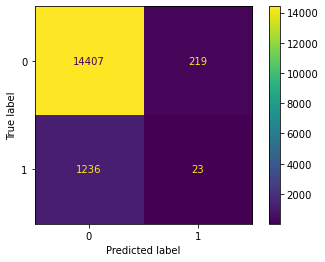

In [9]:
kmeans = KMeans(init='k-means++', n_clusters=2,max_iter=50, n_init=2, random_state=0)
kmeans.fit(X_train,Y_train)
y_hat = kmeans.predict(X_test)
acc = mt.accuracy_score(Y_test,y_hat)
pre = mt.precision_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
auc=roc_auc_score(Y_test,y_hat)
print('Precision',pre)
print('auc',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf)
disp.plot()

## DBScan

In [10]:
eps = [1,2,3,5]
mins = [20,40,60,80]
for x in eps:
    for y in mins:
        db = DBSCAN(eps = x, min_samples = y)
        db.fit(X_train,Y_train)
        y_hat = kmeans.predict(X_test)
        acc = mt.accuracy_score(Y_test,y_hat)
        pre = mt.precision_score(Y_test,y_hat)
        conf = mt.confusion_matrix(Y_test,y_hat)
        auc=roc_auc_score(Y_test,y_hat)
        print('When eps = ',x,'and min_samples = ',y,'Precision:',pre,'AUC:',auc)

When eps =  1 and min_samples =  20 Precision: 0.09504132231404959 AUC: 0.5016475659403803
When eps =  1 and min_samples =  40 Precision: 0.09504132231404959 AUC: 0.5016475659403803
When eps =  1 and min_samples =  60 Precision: 0.09504132231404959 AUC: 0.5016475659403803
When eps =  1 and min_samples =  80 Precision: 0.09504132231404959 AUC: 0.5016475659403803
When eps =  2 and min_samples =  20 Precision: 0.09504132231404959 AUC: 0.5016475659403803
When eps =  2 and min_samples =  40 Precision: 0.09504132231404959 AUC: 0.5016475659403803
When eps =  2 and min_samples =  60 Precision: 0.09504132231404959 AUC: 0.5016475659403803
When eps =  2 and min_samples =  80 Precision: 0.09504132231404959 AUC: 0.5016475659403803
When eps =  3 and min_samples =  20 Precision: 0.09504132231404959 AUC: 0.5016475659403803
When eps =  3 and min_samples =  40 Precision: 0.09504132231404959 AUC: 0.5016475659403803
When eps =  3 and min_samples =  60 Precision: 0.09504132231404959 AUC: 0.5016475659403803

When eps =  1 and min_samples =  3 Precision: 0.09504132231404959 AUC: 0.5016475659403803


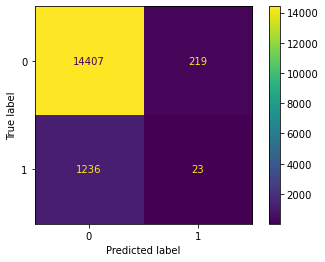

In [17]:
db = DBSCAN(eps = 1, min_samples = 20)
db.fit(X_train,Y_train)
y_hat = kmeans.predict(X_test)
acc = mt.accuracy_score(Y_test,y_hat)
pre = mt.precision_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
auc=roc_auc_score(Y_test,y_hat)
print('When eps = ',x,'and min_samples = ',y,'Precision:',pre,'AUC:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf)
disp.plot()

## Spectral

In [15]:
init = [1,2,5,7,9,10,20,30]
components = [3,5,11,13]
neighbors = [3,5,11,25,45,91]
for y in components:
    for z in neighbors:
        db = SpectralClustering(random_state=0, n_clusters = 2,n_components = y, n_neighbors = z, assign_labels = 'kmeans')
        db.fit(X_train,Y_train)
        y_hat = kmeans.predict(X_test)
        acc = mt.accuracy_score(Y_test,y_hat)
        pre = mt.precision_score(Y_test,y_hat)
        conf = mt.confusion_matrix(Y_test,y_hat)
        auc=roc_auc_score(Y_test,y_hat)
        print('When eps = ',x,'and min_samples = ',y,'Precision:',pre,'AUC:',auc)

MemoryError: Unable to allocate 30.1 GiB for an array with shape (63538, 63538) and data type float64

In [16]:
init = [1,2,5,7,9,10,20,30]
components = [3,5,11,13]
neighbors = [3,5,11,25,45,91]
for y in components:
    for z in neighbors:
        db = SpectralClustering(random_state=0, n_clusters = 2, n_components = y, n_neighbors = z, assign_labels = 'discretize')
        db.fit(X_train,Y_train)
        y_hat = kmeans.predict(X_test)
        acc = mt.accuracy_score(Y_test,y_hat)
        pre = mt.precision_score(Y_test,y_hat)
        conf = mt.confusion_matrix(Y_test,y_hat)
        auc=roc_auc_score(Y_test,y_hat)
        print('When eps = ',x,'and min_samples = ',y,'Precision:',pre,'AUC:',auc)

MemoryError: Unable to allocate 30.1 GiB for an array with shape (63538, 63538) and data type float64

## Section 5: Modeling and Evaluation 2

Evaluate and Compare

...

## Section 6: Modeling and Evaluation 3

Visualize Results

...

## Section 7: Modeling and Evaluation 4

Summarize the Ramifications

...

## Section 8: Deployment

Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

...

## Section 9: Exceptional Work

You have free reign to provide additional analyses or combine analyses.

...